# Imports

In [90]:
! pip install tensorflow_decision_forests wurlitzer



In [91]:

# Imports
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import math
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt

# Plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px

# sseaborn
import seaborn as sns

# Model validation libraries
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import  Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

# Path to files
from google.colab import drive
drive.mount('/content/drive')
 
 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get Dataset

## Init df

In [92]:
# Need to change
path = "/content/drive/Othercomputers/costcoHP/csci5622_ml/proj/musicMoodFolder/audioMoods/models_smallAudioDataset/Spotify-Machine-Learning-master/data/data_moods.csv"

df = pd.read_csv(path)

# Preview some top data rows
df.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


## Useful column feats

In [93]:
COL_FEATS_LABEL =  np.array(['danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'valence', 'loudness','tempo','mood_str','mood'])
COL_FEATURES = np.array(['danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'valence', 'loudness','tempo'])
COL_SONG_INFO = np.array(['name','album', 'artist'])
COL_FEATURES_3 = np.array(['energy', 'valence', 'loudness','mood_str', 'mood'])
LABEL = 'mood'
COL_LABEL = np.array(['mood'])

In [94]:
# Change to use "mood" for y encodings
df = df.rename(columns={"mood": "mood_str"})

# Encode Y Target Categories to values 0-n_classes-1
Y = df['mood_str']
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)
encoded_y

df['mood'] = encoded_y
df


,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood_str,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.7300,0.000000,0.0843,0.6250,-8.201,0.0767,118.523,5,4,Happy,2
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.8320,0.196000,0.1530,0.1660,-5.069,0.0492,120.255,8,4,Sad,3
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.1390,0.000077,0.0934,0.1160,-15.326,0.0321,136.168,0,4,Sad,3
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.4380,0.000006,0.1130,0.5870,-12.858,0.0608,193.100,4,4,Happy,2
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.9320,0.000000,0.1370,0.4450,-3.604,0.1060,169.881,1,4,Energetic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,windcatcher,windcatcher,Leo Nocta,59VApBbrS2IADQk4ml5mdo,2020-06-19,36,123066,0.402,0.96100,0.2360,0.919000,0.0921,0.1460,-20.615,0.0603,129.736,0,3,Calm,0
682,yellow is the color of her eyes,yellow is the color of her eyes,Soccer Mommy,4D3nttJPU6L0M2epr7sId6,2019-11-19,5,435080,0.452,0.75700,0.5150,0.120000,0.1400,0.1910,-7.351,0.0255,80.537,11,4,Sad,3
683,you broke me first,you broke me first,Tate McRae,45bE4HXI0AwGZXfZtMp8JR,2020-04-17,87,169265,0.642,0.78600,0.3740,0.000000,0.0906,0.0799,-9.386,0.0545,124.099,4,4,Sad,3
684,you were good to me,brent,Jeremy Zucker,4CxFN5zON70B3VOPBYbd6P,2019-05-03,76,219146,0.561,0.91300,0.0848,0.000026,0.1120,0.2060,-15.099,0.0404,102.128,2,4,Sad,3


In [95]:
target = pd.DataFrame({'mood_str': df['mood_str'].tolist(), 'encode': encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood_str,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


## df_song_info

In [96]:
df_song_info = df[COL_SONG_INFO]
df_song_info

,name,album,artist
0,1999,1999,Prince
1,23,23,Blonde Redhead
2,9 Crimes,9,Damien Rice
3,99 Luftballons,99 Luftballons,Nena
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath
...,...,...,...
681,windcatcher,windcatcher,Leo Nocta
682,yellow is the color of her eyes,yellow is the color of her eyes,Soccer Mommy
683,you broke me first,you broke me first,Tate McRae
684,you were good to me,brent,Jeremy Zucker


In [97]:
df_feat_3 = df[COL_FEATURES_3]
df_feat_3

,energy,valence,loudness,mood_str,mood
0,0.7300,0.6250,-8.201,Happy,2
1,0.8320,0.1660,-5.069,Sad,3
2,0.1390,0.1160,-15.326,Sad,3
3,0.4380,0.5870,-12.858,Happy,2
4,0.9320,0.4450,-3.604,Energetic,1
...,...,...,...,...,...
681,0.2360,0.1460,-20.615,Calm,0
682,0.5150,0.1910,-7.351,Sad,3
683,0.3740,0.0799,-9.386,Sad,3
684,0.0848,0.2060,-15.099,Sad,3


## df with some feats

In [98]:
df = df[COL_FEATS_LABEL]
df

,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,tempo,mood_str,mood
0,0.866,0.13700,0.7300,0.000000,0.0843,0.6250,-8.201,118.523,Happy,2
1,0.381,0.01890,0.8320,0.196000,0.1530,0.1660,-5.069,120.255,Sad,3
2,0.346,0.91300,0.1390,0.000077,0.0934,0.1160,-15.326,136.168,Sad,3
3,0.466,0.08900,0.4380,0.000006,0.1130,0.5870,-12.858,193.100,Happy,2
4,0.419,0.00171,0.9320,0.000000,0.1370,0.4450,-3.604,169.881,Energetic,1
...,...,...,...,...,...,...,...,...,...,...
681,0.402,0.96100,0.2360,0.919000,0.0921,0.1460,-20.615,129.736,Calm,0
682,0.452,0.75700,0.5150,0.120000,0.1400,0.1910,-7.351,80.537,Sad,3
683,0.642,0.78600,0.3740,0.000000,0.0906,0.0799,-9.386,124.099,Sad,3
684,0.561,0.91300,0.0848,0.000026,0.1120,0.2060,-15.099,102.128,Sad,3


# Splitting dataset

In [99]:
# https://www.tensorflow.org/decision_forests/tutorials/intermediate_colab
def split_dataset(dataset, test_ratio=0.30):
  "splitting pd df in two"

  test_indices = np.random.rand(len(dataset)) < test_ratio

  return dataset[~test_indices], dataset[test_indices]

# Train and test
# test vs trains
train_ds_pd, test_ds_pd = split_dataset(df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Convert dataset to tensor flow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=LABEL)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=LABEL)

###################################################
# # Train Val and Test
# # test vs train&val ds
# train_val_ds_pd, test_ds_pd = split_dataset(df)
# print("{} examples in training&val, {} examples for testing.".format(
#     len(train_val_ds_pd), len(test_ds_pd)))

# # validation vs train ds
# train_ds_pd, val_ds_pd = split_dataset(train_val_ds_pd)
# print("{} examples in training, {} examples for val.".format(
#     len(train_ds_pd), len(val_ds_pd)))

# # Convert dataset to tensor flow dataset
# train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=LABEL)
# val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_ds_pd, label=LABEL)
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=LABEL)


469 examples in training, 217 examples for testing.


/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



# Build Models

In [100]:
# 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'valence', 'loudness','tempo','mood'
input_1 = tf.keras.Input(shape=(1,), name="energy", dtype="float")
input_2 = tf.keras.Input(shape=(1,), name="valence", dtype="float")
input_3 = tf.keras.Input(shape=(1,), name="loudness", dtype="float")

#nn_raw_inputs = [input_1, input_2]
nn_raw_inputs = [input_1, input_2,input_3]


In [101]:
# Normalization
Normalization = tf.keras.layers.Normalization

values = train_ds_pd["energy"].values[:, tf.newaxis]
input_1_normalizer = Normalization()
input_1_normalizer.adapt(values)

values = train_ds_pd["valence"].values[:, tf.newaxis]
input_2_normalizer = Normalization()
input_2_normalizer.adapt(values)

values = train_ds_pd["loudness"].values[:, tf.newaxis]
input_3_normalizer = Normalization()
input_3_normalizer.adapt(values)

normalized_input_1 = input_1_normalizer(input_1)
normalized_input_2 = input_2_normalizer(input_2)
normalized_input_3 = input_3_normalizer(input_3)

nn_processed_inputs = [normalized_input_1, normalized_input_2,normalized_input_3]
#nn_processed_inputs = [normalized_input_1, normalized_input_2]


In [102]:
# Build body of NN
y = tf.keras.layers.Concatenate()(nn_processed_inputs)
y = tf.keras.layers.Dense(16, activation=tf.nn.relu6)(y)
last_layer = tf.keras.layers.Dense(8, activation=tf.nn.relu, name="last")(y)

# "4" moods classes
classification_output = tf.keras.layers.Dense(4)(y)

nn_model = tf.keras.models.Model(nn_raw_inputs, classification_output) # produces classifcation logits

In [103]:
# Build decision forest model
nn_without_head = tf.keras.models.Model(inputs=nn_model.inputs, outputs=last_layer)
df_and_nn_model = tfdf.keras.RandomForestModel(preprocessing=nn_without_head)


Use /tmp/tmp38epg1ok as temporary training directory


## Train and eval models

In [104]:
nn_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"])

nn_model.fit(x=train_ds, validation_data=test_ds, epochs=200)
nn_model.summary()


Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning:

Input dict contained keys ['danceability', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'mood_str'] which did not match any model input. They will be ignored by the model.



1/1 [==============================] - 1s 677ms/step - loss: 1.2502 - accuracy: 0.3774 - val_loss: 1.2671 - val_accuracy: 0.3410
Epoch 2/200
1/1 [==============================] - 0s 29ms/step - loss: 1.2438 - accuracy: 0.3923 - val_loss: 1.2601 - val_accuracy: 0.3502
Epoch 3/200
1/1 [==============================] - 0s 34ms/step - loss: 1.2376 - accuracy: 0.4030 - val_loss: 1.2533 - val_accuracy: 0.3641
Epoch 4/200
1/1 [==============================] - 0s 26ms/step - loss: 1.2314 - accuracy: 0.4158 - val_loss: 1.2465 - val_accuracy: 0.3825
Epoch 5/200
1/1 [==============================] - 0s 26ms/step - loss: 1.2252 - accuracy: 0.4264 - val_loss: 1.2398 - val_accuracy: 0.3917
Epoch 6/200
1/1 [==============================] - 0s 66ms/step - loss: 1.2192 - accuracy: 0.4328 - val_loss: 1.2332 - val_accuracy: 0.4101
Epoch 7/200
1/1 [==============================] - 0s 49ms/step - loss: 1.2132 - accuracy: 0.4435 - val_loss: 1.2267 - val_accuracy: 0.4101
Epoch 8/200
1/1 [==============

In [105]:
df_and_nn_model.fit(x=train_ds)

Starting reading the dataset


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning:

Input dict contained keys ['danceability', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'mood_str'] which did not match any model input. They will be ignored by the model.



1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.365860
Training model
Model trained in 0:00:00.692655
Compiling model
1/1 [==============================] - 1s 1s/step


In [106]:
df_and_nn_model.compile(metrics=["accuracy"])
print("Evaluation:", df_and_nn_model.evaluate(test_ds))


1/1 [==============================] - 1s 533ms/step - loss: 0.0000e+00 - accuracy: 0.7143
Evaluation: [0.0, 0.7142857313156128]


In [107]:
print("Evaluation :", nn_model.evaluate(test_ds))

1/1 [==============================] - 0s 28ms/step - loss: 0.7793 - accuracy: 0.6452
Evaluation : [0.7793294191360474, 0.6451612710952759]


In [108]:
# # Number of trees vs accurancy
# logs = df_and_nn_model.make_inspector().training_logs()
# plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
# plt.xlabel("Number of trees")
# plt.ylabel("Accuracy")

# maxAcc = 0.0
# maxAccTrees = 0
# for log in logs:
#   if  maxAcc < log.evaluation.accuracy:
#     maxAcc = log.evaluation.accuracy
#     maxAccTrees = log.num_trees
# print('max acc:', maxAcc, "maxTree:", maxAccTrees)
# pass



In [109]:
preds = df_and_nn_model.predict(test_ds)
preds = tf.math.argmax(preds,-1)
preds

<tf.Tensor: shape=(217,), dtype=int64, numpy=
array([2, 0, 1, 1, 1, 1, 3, 0, 3, 2, 1, 3, 0, 1, 1, 1, 2, 1, 2, 0, 3, 3,
       0, 3, 0, 1, 0, 1, 1, 0, 2, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 3, 2, 2,
       1, 3, 1, 0, 1, 2, 1, 2, 1, 1, 0, 0, 3, 3, 2, 1, 1, 1, 3, 0, 3, 3,
       2, 1, 3, 3, 0, 0, 2, 1, 3, 3, 1, 1, 2, 2, 0, 3, 2, 3, 0, 3, 2, 2,
       2, 3, 0, 1, 3, 2, 0, 0, 1, 1, 2, 1, 0, 2, 2, 3, 3, 0, 3, 3, 3, 1,
       0, 0, 3, 0, 0, 3, 3, 2, 2, 3, 0, 2, 1, 3, 0, 3, 0, 0, 3, 1, 0, 1,
       0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 2, 1, 0, 0,
       1, 2, 0, 0, 0, 1, 3, 1, 0, 3, 1, 1, 3, 3, 3, 1, 2, 3, 3, 1, 3, 1,
       2, 1, 3, 0, 1, 3, 0, 1, 0, 2, 2, 3, 0, 1, 1, 3, 0, 2, 0, 0, 3, 1,
       1, 0, 0, 0, 3, 1, 0, 0, 3, 3, 2, 3, 2, 3, 0, 3, 0, 3, 0])>

In [110]:
test_ds_pd['preds'] = preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [111]:
def displayPlots(Y_test,y_preds):
    # Display CM and accuracy score
    cm = confusion_matrix(Y_test, y_preds)

    # Plot CM
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)

    # Label CM plot
    ax.set_xlabel('Predicted Labels') # y_hats
    ax.set_ylabel('Gold Truth Labels') # Y_tests
    ax.set_title('Confusion Matrix')
    labels = target['mood_str']
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

    print('Accuracy Score:', accuracy_score(Y_test, y_preds)) # 0.71
# displayPlots()

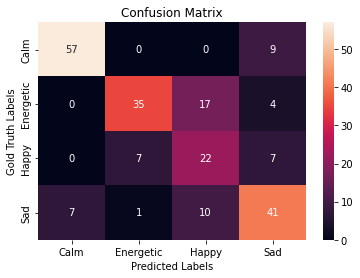

Accuracy Score: 0.7142857142857143


In [112]:
displayPlots(preds, test_ds_pd['mood'])

# Return 4 list for each mood (per mood prediction on test set)


In [113]:
# 5	Calm	0
# 4	Energetic	1
# 0	Happy	2
# 1	Sad	3

Calm_preds = test_ds_pd[ test_ds_pd['preds'] == 0 ]
Energetic_preds = test_ds_pd[ test_ds_pd['preds'] == 1 ]
Happy_preds = test_ds_pd[ test_ds_pd['preds'] == 2 ]
Sad_preds = test_ds_pd[ test_ds_pd['preds'] == 3 ]

In [114]:
Calm_song_list = df_song_info[df_song_info.index.isin(Calm_preds.index)]
Energetic_song_list = df_song_info[df_song_info.index.isin(Energetic_preds.index)]
Happy_song_list = df_song_info[df_song_info.index.isin(Happy_preds.index)]
Sad_song_list = df_song_info[df_song_info.index.isin(Sad_preds.index)]

In [115]:
# TO CSV
Calm_song_list.to_csv('Calm_preds.csv')
Energetic_song_list.to_csv('Energetic_preds.csv')
Happy_song_list.to_csv('Happy_preds.csv')
Sad_song_list.to_csv('Sad_preds.csv')
